#### README

The ultimate goal of the model is to learn a __latent variable space of musical units__. Then, given a musical unit, we wish to encode that unit into a latent vector within the space, and predict the best accompaninment latent vector to that input. Finally, that accompaniment latent vector can be decoded to produce an accompanying musical unit.

This involves many tricky steps, so development will be approached incrementally:

#### 1. Convolutional Autoencoder

Given an input unit of `[num_ticks, num_pitches]`, learn a Convolutional Autoencoder model to generate an encoding of that unit.

```
INPUT -> Convolution layers -> EMBEDDING -> Deconvolution layers -> INPUT
```

Autoencoding: To test this convolutional autoencoder, generate a response to a given input unit using 
- Decoder reconstruction of same input
- Nearest-neighbor unit selection (Similar to what Bretan et al did)

De-noising: Test de-noising abilities of the autoencoder. Given a partial accompaniment input unit, generate a response of
- Decoder reconstruction of "full"/"comp" unit
- Nearest-neighbor unit selection

#### 2. LSTM of latent variables -> Generation using unit selection

Given a sequence of embeddings (from the convolutional autoencoder), predict the next embedding - and perform NN-unit-selection as before, to generate the next unit in the sequence.

#### 3. Convolutional Variational Autoencoder

Learn a new latent space using a VAE architecture (great explanation on VAEs in [this blogpost](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)). Test how well resconstruction works using
- Decoder reconstruction

#### 4. LSTM of variational latent variables -> Generation using latent space sampling 

Given a sequence of embeddings (from the VAE), predict the next embedding and generate an output musical unit by decoding the predicted embedding!!!

#### Imports and user variables

In [50]:
import os, shutil
import random
import sys
import numpy as np
import pypianoroll
from matplotlib import pyplot as plt
import cPickle as pickle
import pianoroll_utils
import IPython
import h5py
import time
from __future__ import print_function
import custom_loss

from sklearn.neighbors import NearestNeighbors
import sklearn.externals

from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard, History
from keras.models import load_model

from scipy.stats import norm
from keras.layers import Lambda, Flatten, Reshape, Dropout
from keras import backend as K
from keras import metrics
from keras import losses

# Music shape
MIN_PITCH = 13 # A-1 (MIDI 21)
MAX_PITCH = 108 # C7 (MIDI 108)
BEATS_PER_UNIT = 4
BEAT_RESOLUTION = 24 # This is set by the encoding of the lpd-5 dataset, corresponds to number of ticks per beat
PARTITION_NOTE = 60 # Break into left- and right-accompaniments at middle C
NUM_PITCHES = MAX_PITCH - MIN_PITCH + 1
NUM_TICKS = BEATS_PER_UNIT * BEAT_RESOLUTION

NUM_FILES = 1000
PICKLE_FILE = './pickle_jar/norm_units_{}_songs_clipped96.pkl'.format(NUM_FILES)
UNITS_FILE = './pickle_jar/units_{}_songs_clipped96.h5'.format(NUM_FILES)

#### Load data

In [ ]:
units = {}
with open(PICKLE_FILE, 'rb') as infile:
    units = pickle.load( infile )
units['full'] = units['input'] + units['comp']

# Print info
print("Loaded", units["input"].shape[0], "units from", PICKLE_FILE)
print("input_units.shape: ", units["input"].shape)
print("input_units.shape: ", units["input_noisy"].shape)
print("comp_units.shape: ", units["comp"].shape)
print("full_units.shape: ", units["full"].shape)

# Create an array of True (train) and False (test) to split the dataset
# Also reshape each pianoroll from (128, 96) to (128, 96, 1); 
# the '1' corresponds to number of img channels
train_test_indices = np.random.choice([True, False], size=len(units["input"]), p=[.9, .1])
# Training data
input_train = units["input"][train_test_indices, ...].reshape(-1, NUM_PITCHES, NUM_TICKS, 1)
input_train_noisy = units["input_noisy"][train_test_indices, ...].reshape(-1, NUM_PITCHES, NUM_TICKS, 1)
comp_train = units["comp"][train_test_indices, ...].reshape(-1, NUM_PITCHES, NUM_TICKS, 1)
full_train = units["full"][train_test_indices, ...].reshape(-1, NUM_PITCHES, NUM_TICKS, 1)
# Testing data
input_test = units["input"][np.invert(train_test_indices), ...].reshape(-1, NUM_PITCHES, NUM_TICKS, 1)
input_test_noisy = units["input_noisy"][np.invert(train_test_indices), ...].reshape(-1, NUM_PITCHES, NUM_TICKS, 1)
comp_test = units["comp"][np.invert(train_test_indices), ...].reshape(-1, NUM_PITCHES, NUM_TICKS, 1)
full_test = units["full"][np.invert(train_test_indices), ...].reshape(-1, NUM_PITCHES, NUM_TICKS, 1)
print "Train:", input_train.shape
print "Test:", input_test.shape

In [35]:
# Load dataset
f = h5py.File(UNITS_FILE, 'r')

# Training data
input_train = f['units_train']
input_train_noisy = f['units_train_noisy']
# Testing data
input_test = f['units_test']

print("Train:", input_train.shape)
print("Noisy train:", input_train_noisy.shape)
print("Test:", input_test.shape)

Train: (220409, 96, 96, 1)
Noisy train: (220409, 96, 96, 1)
Test: (20426, 96, 96, 1)


# 1. Convolutional Autoencoder

## Preamble

Given an input unit of `[num_ticks, num_pitches]`, learn a Convolutional Autoencoder model to generate an encoding of that unit.

```
INPUT -> Convolution layers -> EMBEDDING -> Deconvolution layers -> INPUT
```

### Testing

We will evaluate the autoencoder using two measures:

1. __Autoencoding__: To test this convolutional autoencoder, generate a response to a given input unit using 

    - Decoder reconstruction of same input
    - Nearest-neighbor unit selection (Similar to what Bretan et al did)

2. __De-noising__: Test de-noising abilities of the autoencoder. Given a partial accompaniment input unit, generate a response of

    - Decoder reconstruction of "full"/"comp" unit
    - Nearest-neighbor unit selection

    (inspired by Huang et al Counterpoint by Convolution, and Bretan et al Learning and Evaluating Musical Features with Deep Autoencoders)

These two tests simply require training the model on two different datasets: "full"->"full" for autoencoding, and "input"->"comp" for de-noising.

### Architecture


_Initial code adapted from the [Keras tutorial on autoencoders](https://blog.keras.io/building-autoencoders-in-keras.html)._

_Inspiration for convolution autoencoder network from "Learning and Evaluating Musical Features with Deep
Autoencoders"._

## Autoencoder V0

### Details

Based on "Learning and Evaluating Musical Features with Deep Autoencoders", but adapted for different input size.

```
Data: -
Embedding shape: (None, 1, 1, 800) -> 800 elements
Epochs: -
Batch size: -
Final loss: -
```

### Notes

Pretty sophisticated model, but unfortunately not able to train due to a `ResourceExhaustedError` upon running `model.fit`. This is most likely due to insufficient GPU memory (model is very large).

Several attempts were made to shrink the model / reduce batch size (which apparently helps), but was not able to shake the error.

### Next steps
1. Look at how to shrink this model / use an alternative model. This [SO thread](https://stackoverflow.com/questions/41526071/why-is-keras-throwing-a-resourceexhaustederror) may be helpful.

In [ ]:

input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)

## ENCODER

# First four layers are Conv2D
x = Conv2D(100, (13, 21), strides=(5,5), activation='relu', padding='valid')(input_mat)
x = BatchNormalization(axis=3)(x)
x = Conv2D(200, (2, 7), strides=(2,3), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(400, (2, 2), strides=(2,2), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2D(800, (2, 2), strides=(2,1), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
# Following three are fully connected
x = Conv2D(800, (3, 1), strides=(1,1), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Dense(400, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
encoded = BatchNormalization()(x)

# at this point the representation is a 100-dimensional vector

## DECODER

# Two fully connected
decoded = Dense(400, activation='relu')(encoded)
x = BatchNormalization()(x)
x = Conv2DTranspose(800, (3, 1), strides=(1,1), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
# Deconvolution / Convolution Transpose layers
x = Conv2DTranspose(800, (2, 2), strides=(2,1), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2DTranspose(400, (2, 2), strides=(2,2), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2DTranspose(200, (2, 7), strides=(2,3), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2DTranspose(100, (13, 21), strides=(5,5), activation='relu', padding='valid')(x)
x = BatchNormalization(axis=3)(x)
x = Conv2DTranspose(1, (NUM_TICKS, NUM_PITCHES), activation='relu', padding='valid')(x)
decoded = BatchNormalization(axis=3)(x)

autoencoder = Model(input_mat, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

In [ ]:
# Train model model
autoencoder.fit(input_train, input_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
# Run `tensorboard --logdir=/tmp/autoencoder` to start tensorboard

## Autoencoder V1

`code given below`

### Details

Pretty arbitrary variant of the convolutional autoencoder architecture suggested in the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html).

```
Data: input->input
Embedding shape: (None, 32, 24, 32) -> 24576 elements
Epochs: 100
Batch size: 32
Final loss: [loss: -0.0047 - val_loss: -0.0052]
```

### Notes

#### Test \#1
~~Final binary crossentropy loss (after 100 epochs) gives `loss: -0.0047 - val_loss: -0.0052`, which is strange since __I don't think binary crossentropy should give negative values__? Will have to investigate further.~~ 

Besides that, the decoded output looks really good. The graphs and playback are almost indistinguishable - can notice what appears to be quantization effects in the graphs, and some difference (note drops/additions, incorrect pitch) is occasionally audible. But mostly similar. 

On the whole, this model was a successful "trial" model. Demonstrates that the autoencoder actually produces a valid pianoroll, but our __input size was 12288 and embedding size is 24576__, which actually enlarges the dimensionality instead of shrinking it.

#### Test \#2
Tried `input->comp`, it also sounds like someone dropped a piano off a cliff (like in AEV2). 

#### Test \#3
Tried `input->full`, it sounds like a baby crawling across the keyboard while a pianist is playing. Which is to say it's better than `input->comp` (as expected), but only marginally so, and there's still no proof that this particular model will ever be able to learn accompaniments (at least on this dataset).

It's clear from the pianoroll plot, that the "dropped piano" sound comes from the fact that almost all values are non-zero (hence all notes are sounding at the same time). Which in hindsight is not surprising, given a continuous prediction space. Perhaps we need to __tweak the loss function to impose a penalty on too many notes sounding at the same time__?

#### Follow-up: Fixing the dropped-piano problem
Holy shit this made all the difference!!! 

```
# Set all velocity values < threshold to zero
sample_output[sample_output < 10] = 0
```

Output sounds sooo much better now.

For the case of `input->full`, you can now clearly hear the input recreated in the output (which is what we expect), but there are also some additional notes thrown into the mix (though they aren't always "good" accompaniment notes).

For the case of `input->comp`, which we expect to be more difficult, the comp notes are actually not very bad! They aren't very perfect, but they actually sound musically-coherent! Very interesting...

### Next steps
1. ~~Investigate negative loss values ([most likely](https://github.com/Lasagne/Recipes/issues/54) due to some normalization issue)~~ (Fixed with correct normalization of data in data_prep)
2. ~~Train on input->comp~~ (Tried, it sucks)
3. ~~Train on input->full~~
4. Shrink the embedding layer!!
5. Some sort of unit selection task

In [ ]:

input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)

# ENCODER
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_mat)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# At this point, the data is already represented in the embedding

# DECODER
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_mat, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

In [ ]:
# Train model model
autoencoder.fit(input_train, input_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v1.h5'
autoencoder.save(MODEL_AUTOENCODER_V1_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V1_FILE

In [ ]:
# Train model model
autoencoder.fit(input_train, comp_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, comp_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v1_input_comp.h5'
autoencoder.save(MODEL_AUTOENCODER_V1_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V1_FILE

In [ ]:
# Train model model
autoencoder.fit(input_train, full_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, full_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v1_input_full.h5'
autoencoder.save(MODEL_AUTOENCODER_V1_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V1_FILE

In [ ]:
MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v1_input_comp.h5'
autoencoder = load_model(MODEL_AUTOENCODER_V1_FILE)

In [ ]:
# Run test inputs through the autoencoder
decoded_test = autoencoder.predict(input_test)

In [ ]:
# Inspect a random input-output sample
# sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_comp = comp_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_output = decoded_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Set all velocity values < threshold to zero
sample_output[sample_output < 10] = 0

print(sample_input.shape)
print(sample_comp.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Comp')
ax[2].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[1], sample_comp, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[2], sample_output, beat_resolution=24)
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
pianoroll_utils.playPianoroll(sample_comp)
pianoroll_utils.playPianoroll(sample_output)
pianoroll_utils.playPianoroll(sample_input+sample_output)


## Autoencoder V2

`code given below`

### Details

Iterating on the faults of the previous model: 
1. Change from an `input->input` autoencoder to a `input->comp` de-noising autoencoder,
2. Reduce size of embedding layer by increasing number of conv/pooling layers.

```
Data: input->comp, input->input
Embedding shape: (None, 3, 2, 100) -> 600 elements
Epochs: 50
Batch size: 128
Final loss: [loss: 0.0322 - val_loss: 0.0334]
```

### Notes

#### Test \#1
`input->comp`

This test was an absolute disaster! The output produced _actually_ sounded like someone dropping a piano off a cliff (which is fun but not very useful for the purpose of this project).

Interesting things to note - the training and validation loss started at `loss: 0.0375 - val_loss: 0.0302`, then ended at `[loss: 0.0322 - val_loss: 0.0334]`, barely learning anything at all. The model seemed to be improving consistently at the beginning, reaching a loss of about `0.02` at the halfway point (25th epoch), but then started getting worse consistently. Why did this happen? I thought that GD should only ever improve the model (or in the case of BGD, deteriorate slightly but improve overall). Also, what I hear is clearly not only 2% error. Maybe need to re-evaluate the loss function.

One other thing about the model, is that perhaps it is too much to expect it to be able to predict the left and right accompaniments. Might be worth trying `input->full` instead of `input->comp`, and maybe think of a completely new way to structure the data...

Finally, the model itself was also changed significantly from the previous version. Maybe the drop in hidden layer dimension is too steep, or the embedding size is too small. Should test with basic `input->input` case first.

#### Test \#2
`input->input`

Hmm, interestingly this wasn't any better than the input->comp instance. Which implies that the model itself is broken. Onwards!

#### Follow-up

Applying a threshold-to-zero filter on notes with low velocity helped in removing the "dropped piano" noise, but the remaining output was consistently bad. It appears that the model is taking wild guesses with too many notes at low velocities (close to no notes remain after a velocity-50 threshold), even for the simplest `input-input` autoencoder task.

Comparing this to AEV1, we can conclude that the output thresholding is likely a good idea, and that the right network should indeed be able to reproduce a close decoding. The good performance of AEV1 and poor performance of AEV2 implies that the data is usable, the loss function is acceptable, and most likely the main problem is just finding the right autoencoder network. This should be the next priority - designing a network which produces a smaller embedding than AEV1 while maintaining output quality.

### Next steps
1. Investigate output (why doesn't the pianoroll plot look like a piano being thrown off a cliff?)
2. Investigate behaviour of the trainig/validation losses.
3. ~~Try using `input-input` and `input-full` to make sure the model can actually something useful.~~ 
4. Try a different autoencoder architecture.

In [ ]:

input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)

# ENCODER
x = Conv2D(200, (13, 21), strides=(5,5), activation='relu', padding='valid')(input_mat)
x = BatchNormalization()(x)

x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# At this point, the data is already represented in the embedding

# DECODER
x = Conv2D(100, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(200, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2DTranspose(1, (13, 21), strides=(5,5), activation='relu', padding='valid')(x)

autoencoder = Model(input_mat, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

In [ ]:
# Train model [INPUT->COMP]
autoencoder.fit(input_train, comp_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(input_test, comp_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V2_FILE = './models/autoencoder_v2.h5'
autoencoder.save(MODEL_AUTOENCODER_V2_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V2_FILE

In [ ]:
# Train model [INPUT->INPUT]
autoencoder.fit(input_train, input_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V2_FILE = './models/autoencoder_v2_input_input.h5'
autoencoder.save(MODEL_AUTOENCODER_V2_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V2_FILE

In [ ]:
MODEL_AUTOENCODER_V2_FILE = './models/autoencoder_v2_input_input.h5'
autoencoder = load_model(MODEL_AUTOENCODER_V2_FILE)

In [ ]:
# Run test inputs through the autoencoder
decoded_test = autoencoder.predict(input_test)

In [ ]:
# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
# sample_comp = comp_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_output = decoded_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Set all velocity values < threshold to zero
sample_output[sample_output < 20] = 0

print(sample_input.shape)
# print(sample_comp.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
# ax[1].set_title('Target')
ax[1].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24)
# pypianoroll.plot_pianoroll(ax[1], sample_comp, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[1], sample_output, beat_resolution=24)
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
# pianoroll_utils.playPianoroll(sample_comp)
pianoroll_utils.playPianoroll(sample_output)


## Autoencoder V3 - Unit Selection

`code given below`

### Details

The focus of this model is to use a small enough embedding layer, such that we can do nearest-neighbour unit selection.

```
Data: input->input
Embedding shape: (None, 3, 2, 100) -> 600 elements
Epochs: 50
Batch size: 128
Final loss: 
```

We begin with a baseline embedding of 600 elements (by comparison, Bretan uses a 500-value embedding), loaded directly from AEV2 ([reference](https://github.com/keras-team/keras/issues/41) for loading encoder weights in Keras; [docs](https://keras.io/layers/about-keras-layers/) on Keras layers). 

### Notes

Pretty happy with this! Lots more to go, but I'm glad to have a working implementation of unit selection - it's quite a milestone to have something that successfully uses an encoder to get an embedding, which we can subsequently do nearest-neighbor selection from!

This is my first approach which produces non-piano-off-the-cliff results, which is encouraging. But then again, legible output is pretty much guaranteed by the unit selection method, so it's still to early to celebrate.

Interestingly, testing the system with training data does not give back the exact same input, but it seems to give a reasonably "close-sounding" match. Which is reasonable, given that our embedding dimensionality is so much smaller than the original. 

Using testing data, the corresponding kNN match is much less similar to the data, which is expected to some extent. There seems to be some sort of rhythmic or note-density similarities in the input->matched pair, but this may be my own confirmation bias. 

Most important thing to do now is to find a way to measure the "appropriateness" of the generated outputs, and then we can start to benchmark/quantify our results. :))

### Next steps
1. Try different embeddings
2. Quantify results

In [ ]:
MODEL_AUTOENCODER_V2_FILE = './models/autoencoder_v2_input_input.h5'
ae_V2 = load_model(MODEL_AUTOENCODER_V2_FILE)

In [ ]:
# for layer in ae_V2.layers:
#     print layer, len(layer.get_weights())

In [ ]:
# Recreate just the encoder portion of AEV2 
input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)

# ENCODER
x = Conv2D(200, (13, 21), strides=(5,5), activation='relu', padding='valid')(input_mat)
x = BatchNormalization()(x)

x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder = Model(input_mat, encoded)
encoder.compile(optimizer='adam', loss='binary_crossentropy')

## Load up the weights trained with AEV2
for i, layer in enumerate(encoder.layers):
    encoder.layers[i].set_weights(ae_V2.layers[i].get_weights())


In [ ]:
MODEL_FILE = './models/encoder_v2_input_input.h5'
encoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
del encoder
encoder = load_model(MODEL_FILE)

In [ ]:
def getFlattenedEncodings(inputs, enc):
    """
    Given an input matrix of shape (M, 128, 96, 1) and a trained encoder model,
    run each M pianorolls through the encoder and return an (M, F) matrix 
    where F is the length of the FLATTENED embedding layer.
    """
    assert inputs.shape[1] == 128
    assert inputs.shape[2] == 96
    assert inputs.shape[3] == 1
    
    encodings = enc.predict(inputs)
    flat_encodings = encodings.reshape(encodings.shape[0], -1)
    return flat_encodings

# Build a dataset of embeddings of our input units
encoded_inputs = getFlattenedEncodings(input_train, encoder)
print(encoded_inputs.shape)

In [ ]:
from sklearn.neighbors import NearestNeighbors
import sklearn.externals

# Training the nearest neighbors model
knn_model = NearestNeighbors(n_neighbors=1).fit(encoded_inputs)

# Save model along with the units used to learn the model
KNN_MODEL_FILENAME = "./models/unit_selector_knn.pkl"
sklearn.externals.joblib.dump((knn_model, input_train, comp_train), KNN_MODEL_FILENAME)

In [ ]:
# Testing the model with training data!

# Choose a sample input to find the nearest neighbor of 
# (in this case, the 1nn should be itself, or a unit which is almost identical to itself)
sample_index = np.random.randint(len(input_train))
sample_input = input_train[sample_index].reshape(1, 128, 96, 1)
sample_encoding = getFlattenedEncodings(sample_input, encoder)
# Prediction
knn_index = knn_model.kneighbors(sample_encoding, return_distance = False)[0][0]
print sample_index, knn_index

sample_input = input_train[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
knn_input = input_train[knn_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
knn_comp = comp_train[knn_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Full')
ax[2].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[1], knn_input, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[2], knn_comp, beat_resolution=24)
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
pianoroll_utils.playPianoroll(knn_input)
pianoroll_utils.playPianoroll(knn_comp)

In [ ]:
# Testing the model with test data!

# Inspect a random input-output sample
# Choose a test input to find the nearest neighbor of
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].reshape(1, 128, 96, 1)
sample_encoding = getFlattenedEncodings(sample_input, encoder)
# Prediction
knn_index = knn_model.kneighbors(sample_encoding, return_distance = False)[0][0]
sample_input = input_train[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
knn_input = input_train[knn_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
knn_comp = comp_train[knn_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Full')
ax[2].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[1], knn_input, beat_resolution=24)
pypianoroll.plot_pianoroll(ax[2], knn_comp, beat_resolution=24)
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
pianoroll_utils.playPianoroll(knn_input)
pianoroll_utils.playPianoroll(knn_comp)


## Autoencoder V4

`code given below`

### Details

Trying to reduce the embedding size of AEV1 without losing all musicality (as happened in AEV2).

```
Data: input->input
Embedding shape: (None, 3, 2, 100) -> 600 elements
Epochs: 100
Batch size: 32
Final loss: [loss: -0.0047 - val_loss: -0.0052]
```

### Notes

#### Attempt \#1

Adding more conv-pooling pairs (even just one more) to AEV1 had a devastating effect on the decoded output. The training/validation loss also seemed to stagnate at around 16% after just one or two iterations, so I quickly aborted the mission.

#### Attempt \#2

Tried to copy the model of AEV2, but removed one conv-pooling pair in hopes that the output would be better than AEV2. Not much difference.

#### Attempt \#3

**Here's where it gets so much better**: AEV2 with one less conv-pooling pair, and changed the loss function from binary crossentropy to _mean-squared error_, and the results are MAGNITUDES BETTER. (I mean, who's bright idea was it to use binary crossentropy for a pianoroll matrix anyway?) 

The output is acceptable (sounds mostly similar to the input except for some stray wrong notes or occasional dropped notes) even without any thresholding to zero. 

The best loss now is: `loss: 4.7768e-04 - val_loss: 8.2842e-04`. The logical next step will be to add back the conv-pooling pair and see what happens...

#### Attempt \#4

Recap: The model is exactly the same as AEV2, but with mean-squared error instead of binary crossentropy. This makes sense, and (more importantly?) it gives a good decoded output with an embedding size of just 600! 

The best loss now is: `loss: 0.0010 - val_loss: 0.0015` which is slightly poorer than the previous attempt, but this is expected given that we have shrunk the embedding size from 2400 to 600 (This is a good thing, but may not be necessary considering the tradeoff in reconstruction accuracy).

Importantly, we begin to get a sense of how the convolutional autoencoder starts to fail in this current architecture - the notes are treated simply as numbers - there is no category, no understanding of relationship between notes, which pairs go together, and whatnot. The autoencoder tries to numerically approximate the closest numerical reconstruction, but does not appear to have learnt any musical rules (this is my guess, given the seeming randomness of wrong note-attempts and note drops in the reconstruction).

As such, I expect that the model will do quite poorly in the next task: to learn a encoder-decoder mapping for `input->full`.

#### Attempt \#5

Here, for the task of `input->full`, we approach the limitations of our current approach. The reconstruction is actually not very bad - the output is doing well at replicating the input, but the 'accompaniment' it adds on to the input to make it more full, are more often than not, bad choices. Overall, the output sounds acceptable, and on occasion the accompaniment seems interesting and almost believable as the work of a particularly audacious composer. But alas, this is not enough.

The important thing to remember now, before running off to change from a convolutional autoencoder to a one-hot encoded RNN autoencoder, is that if we can successfully create a variational autoencoder, it may not be necessary at all to master the `input->full` or `input->comp` tasks (although I cannot deny how wonderful it would be to do so)! 

A variational autoencoder would give us the flexibility (via latent space arithmetic) to produce a sufficiently different output given an input, that it would no longer be considered a copy! So, so long as we can learn a musically correct latent space, we are in the gold.

#### Attempt \#6

Task: `input->comp`. Results: Actually much better than I thought it would be! But the main observation comes after trying to integrate it into the demo - the output sounds much less interesting (few, unconvincing notes) than what happens here when listening to a test sample. This is most probably a data problem: The test set are too similar to the training set (presumably due to repetition in many songs) to actually give the true test error, so the model is probably overfit on the current songs, which are far too few.

Thus, it is important to try again on the much larger full dataset as soon as possible, and if that doesn't work, we may need to record our own dataset based on my playing (since that will be the target user input).

### Next steps
1. ~~Try putting this into a live demo context. :)~~ Tried. Unfortunately live input seems to work much more poorly than the test input, maybe because the input distribution is too different from the training distribution?
2. Start work on RNNs for next-unit prediction.
3. Consider changing the convolutional autoencoder architecture (though this should hardly be a priority for now).

In [ ]:

input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)

# ENCODER
x = Conv2D(200, (13, 21), strides=(5,5), activation='relu', padding='valid')(input_mat)
x = BatchNormalization()(x)

x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# At this point, the data is already represented in the embedding

# DECODER
x = Conv2D(100, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(200, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2DTranspose(1, (13, 21), strides=(5,5), activation='relu', padding='valid')(x)

autoencoder = Model(input_mat, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
autoencoder.summary()

In [ ]:
# Train model model
autoencoder.fit(input_train, input_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, input_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v4.h5'
autoencoder.save(MODEL_AUTOENCODER_V1_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V1_FILE

In [ ]:
# Train model model
autoencoder.fit(input_train, full_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, full_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v4_input_full.h5'
autoencoder.save(MODEL_AUTOENCODER_V1_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V1_FILE

In [ ]:
# Train model model
autoencoder.fit(input_train, comp_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(input_test, comp_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

MODEL_AUTOENCODER_V1_FILE = './models/autoencoder_v4_input_comp.h5'
autoencoder.save(MODEL_AUTOENCODER_V1_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_AUTOENCODER_V1_FILE

In [ ]:
MODEL_AUTOENCODER_FILE = './models/autoencoder_v4_input_comp.h5'
autoencoder = load_model(MODEL_AUTOENCODER_FILE)

In [ ]:
# Run test inputs through the autoencoder
decoded_test = autoencoder.predict(input_test)
print decoded_test.shape

In [ ]:
# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_full = full_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_output = decoded_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Set all velocity values < threshold to zero
sample_output[sample_output < 10] = 0
sample_output[sample_output >= 10] = 80

print(sample_input.shape)
print(sample_full.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Target')
ax[2].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[1], sample_full, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[2], sample_output, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Play comparison
pianoroll_utils.playPianoroll(sample_input)
# pianoroll_utils.playPianoroll(sample_full)
# pianoroll_utils.playPianoroll(sample_output)
pianoroll_utils.playPianoroll_events(sample_output.swapaxes(0,1))



## Variational Autoencoder V1

`code given below`

### Details

Trying to adapt the model of AEV4 into a variational autoencoder. Code adapted from [this tutorial](https://blog.keras.io/building-autoencoders-in-keras.html), and [this example](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py).

```
Data: input->input
Embedding shape: 2400
Epochs: 50
Batch size: 32
Final loss: loss: 266.8356 - val_loss: 273.1442
```

### Notes

#### Attempt 1 (at least, first recorded one haha)
```
Latent dim = 2400
Intermediate_dim = None (removed all dense layers except latent)
Kernel size = (3,3)
Output activation: sigmoid
Loss: xent + kldiv
Optimizer: adam
Best error: loss: 375.8985 - val_loss: 364.5504 (after 10 epochs)
```

Actually not that bad. There is some inkling of the original sound in the output, but notes are held pretty much all the time (similar problem as we saw in RNNs).

#### Attempt 2
```
Attempt 1 modified
Output activation: relu
Best error: Around 2000
```

Quite terrible, loss wasn't even going down. Aborted.

#### Attempt 3
```
Attempt 1 modified
Kernel size = (6,6)
Best error: loss: 390.4387 - val_loss: 384.1872
```

Not easily distinguishable from Attempt 1, but seems a little worse based on loss.

#### Attempt 3
```
Attempt 1 modified
Loss: mse + kldiv
Best error: Plateau and stayed at (loss: 0.0080 - val_loss: 0.0082) after 3 epochs
```

This is nowhere as good as the xent error version (why?). It seems to learn a completely uniformly 0 (or close to zero) output across the whole matrix.

#### Attempt 4
```
Attempt 1 modified
Latent dim: 600 (achieved by adding one more convolutional+max pooling pair)
Best error: loss: 413.7631 - val_loss: 403.9150
```

Unsurprisingly, it does a little worse than original (since we have a smaller latent dimension).

#### Attempt 5 (saved as vae_v1.h5)
```
Attempt 1 modified
Epochs: 50
Best error: loss: 266.8356 - val_loss: 273.1442
```

SOOOOO much better! Successfully maintains some semblance of the input even without output quantization, but still struggles heavily with more complicated note sequences (seems to only learn the note onsets and always drags the note out to the end of the unit).

#### Attempt 6
```
Attempt 1 modified
Optimizer: rmsprop
Epochs: 50
Best error: loss: 283.0813 - val_loss: 312.6207
```

Almost the same as adam, but slightly poorer learning. Best to stick with adam.


### Next steps
1. Investigate using a different dataset: Try maybe 2-beat measures, drop from 128 to 88 pitches. 
2. Also, **seriously consider** changing to a one-hot encoded scheme!

#### Autoencoder portion

In [ ]:
latent_dim = 2400
intermediate_dim = 600
epsilon_std = 1.0
NUM_PITCHES = 128
NUM_TICKS = 96

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., # latent_dim
                              stddev=epsilon_std) # epsilon_std
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Encoder stuff
input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)
x = Conv2D(200, (13, 21), strides=(5,5), activation='relu', padding='valid')(input_mat)
x = BatchNormalization()(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
# x = Dense(intermediate_dim, activation='relu')(x)

# Modelling the embedding
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) # "output_shape" not needed using tf backend

# Decoder stuff
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_reshape = Reshape((6, 4, 100))
decoder_conv1 = Conv2D(100, (3, 3), activation='relu', padding='same')
decoder_upsamp1 = UpSampling2D((2, 2))
decoder_conv2 = Conv2D(100, (3, 3), activation='relu', padding='same')
decoder_upsamp2 = UpSampling2D((2, 2))
decoder_conv3 = Conv2D(200, (3, 3), activation='relu', padding='same')
decoder_upsamp3 = UpSampling2D((2, 2))
decoder_conv4 = Conv2DTranspose(1, (13, 21), strides=(5,5), activation='sigmoid', padding='valid')
# now we apply the decoder layers we previously defined
# x = decoder_hid(z)
x = decoder_reshape(z)
# x = decoder_conv1(x)
# x = decoder_upsamp1(x)
x = decoder_conv2(x)
x = decoder_upsamp2(x)
x = decoder_conv3(x)
x = decoder_upsamp3(x)
x_decoded_mean = decoder_conv4(x)

# instantiate VAE model
autoencoder = Model(input_mat, x_decoded_mean)

# Compute VAE loss
def vae_loss(input_x, output_x):
    xent_loss = NUM_PITCHES * NUM_TICKS * metrics.binary_crossentropy(K.flatten(input_x), K.flatten(output_x))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

# def vae_loss(input_x, output_x):
#     mse_loss = K.mean(K.square(K.flatten(input_x) - K.flatten(output_x)))
#     kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#     return K.mean(mse_loss + kl_loss)

autoencoder.compile(optimizer='adam', loss=vae_loss)
autoencoder.summary()

In [ ]:
# Train the VAE model
autoencoder.fit(input_train, input_train,
        epochs=50,
        batch_size=32,
        shuffle=True,
        validation_data=(input_test, input_test))

MODEL_FILE = './models/vae_v1.h5'
autoencoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
# Encoder model
encoder = Model(input_mat, z_mean)

MODEL_FILE = './models/vae_v1_encoder.h5'
encoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

# Decoder model
_z = Input(shape=(latent_dim,))
# _x = decoder_hid(_z)
_x = decoder_reshape(_z)
# _x = decoder_conv1(_x)
# _x = decoder_upsamp1(_x)
_x = decoder_conv2(_x)
_x = decoder_upsamp2(_x)
_x = decoder_conv3(_x)
_x = decoder_upsamp3(_x)
_x_decoded_mean = decoder_conv4(_x)
generator = Model(_z, _x_decoded_mean)

MODEL_FILE = './models/vae_v1_generator.h5'
generator.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
MODEL_FILE = './models/vae_v1.h5'
autoencoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std, 'vae_loss': vae_loss})
MODEL_FILE = './models/vae_v1_encoder.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v1_generator.h5'
generator = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

In [ ]:
# Run test inputs through the autoencoder
decoded_test = autoencoder.predict(input_test)
print decoded_test.shape

In [ ]:
# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_full = full_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_output = decoded_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Set all velocity values < threshold to zero
sample_output[sample_output < 10] = 0
sample_output = np.clip(sample_output * 2, 0, 127)

print(sample_input.shape)
print(sample_full.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Target')
ax[2].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[1], sample_full, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[2], sample_output, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Play comparison
pianoroll_utils.play_pianoroll_events(sample_input.T)
# pianoroll_utils.play_pianoroll_events(sample_full)
# pianoroll_utils.play_pianoroll_events(sample_output)
pianoroll_utils.play_pianoroll_events(sample_output.T)


In [ ]:
# Encoding-decoding test
sample_index = np.random.randint(len(input_test))
x = input_test[sample_index].reshape(1, input_test[sample_index].shape[0], input_test[sample_index].shape[1], 1)

z = encoder.predict(x)
x_decoded = generator.predict(z)

print(x.shape)
print(z.shape)
print(x_decoded.shape)

# Playback
sample_input = input_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_output = x_decoded[0].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

pianoroll_utils.play_pianoroll_events(sample_input.T)
pianoroll_utils.play_pianoroll_events(sample_output.T)

## Variational Autoencoder V2

Using architecture inspired by [this tutorial](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py). 

In [ ]:
img_chns = 1
latent_dim = 128
intermediate_dim = 1024
filters = 64
num_conv = 3

epsilon_std = 1.0
NUM_PITCHES = 128
NUM_TICKS = 96

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., # latent_dim
                              stddev=epsilon_std) # epsilon_std
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Encoder stuff
x = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))
conv_0 = Conv2D(200, (13, 21), strides=(5,5), activation='relu', padding='valid')(x)
batch_norm = BatchNormalization()(conv_0)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(batch_norm)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 12 * 8, activation='relu')
decoder_reshape = Reshape((12, 8, filters))
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

decoder_deconv_0 = Conv2DTranspose(1, (13, 21), strides=(5,5), activation='sigmoid', padding='valid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
x_decoded_mean_squash = decoder_deconv_0(x_decoded_mean_squash)

# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# Compute VAE loss
# def vae_loss(input_x, output_x):
#     xent_loss = NUM_PITCHES * NUM_TICKS * metrics.binary_crossentropy(K.flatten(input_x), K.flatten(output_x))
#     kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#     return K.mean(xent_loss + kl_loss)

def vae_loss(input_x, output_x):
    mse_loss = K.mean(K.square(K.flatten(input_x) - K.flatten(output_x)))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(mse_loss + kl_loss)

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()


In [ ]:
# Train the VAE model
vae.fit(input_train, 
        epochs=50,
        batch_size=32,
        shuffle=True,
        validation_data=(input_test, None))

MODEL_FILE = './models/vae_v2.h5'
vae.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
# Run test inputs through the autoencoder
decoded_test = vae.predict(input_test)
print decoded_test.shape

In [ ]:
# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_full = full_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_output = decoded_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Set all velocity values < threshold to zero
# sample_output[sample_output < 10] = 0
# sample_output[sample_output >= 10] = 80

print(sample_input.shape)
print(sample_full.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Target')
ax[2].set_title('Output')
pypianoroll.plot_pianoroll(ax[0], sample_input, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[1], sample_full, beat_resolution=24, cmap='inferno')
pypianoroll.plot_pianoroll(ax[2], sample_output, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Play comparison
# pianoroll_utils.playPianoroll(sample_input)
# pianoroll_utils.playPianoroll(sample_full)
# pianoroll_utils.playPianoroll(sample_output)
# pianoroll_utils.playPianoroll_events(sample_output.swapaxes(0,1))



## Variational Autoencoder V3

`code given below`

### Details

Testing the model of VAEV1 on new 88-pitch dataset, 200 songs. GCP debut woot woot! Also trying larger batch size.

```
Data: input->input
Embedding shape: 1600
Epochs: 50
Batch size: 128
Final loss:
```

### Notes

#### Attempt 1
```
Latent dim = 1600
Intermediate_dim = None (removed all dense layers except latent)
Kernel size = (3,3)
Output activation: sigmoid
Loss: xent + kldiv
Optimizer: adam
Best error: loss: 208.0337 - val_loss: 212.2165 (after 50 epochs)
```

This GCP comper-gpu machine is AMAZEBALLLSSSS. Training 18000+ samples in like 5 minutes, didn't even break a sweat. WOOOHOOO. 

On the other hand, the actual reconstructed output isn't that much better, unfortunately. The output certainly looks a lot more convincing, but there's still a problem of ghost notes and random wrong notes - which makes the playback sound less than ideal.

### Next steps
1. Best bet from here is probably to implement the tick-vocabulary thing (word2vec), and go from convolutional autoencoder to RNN-autoencoder.
2. But before that, let's try to do the next step prediction thing. :)

#### Autoencoder portion

In [ ]:
latent_dim = 1600
intermediate_dim = 600
epsilon_std = 1.0
NUM_PITCHES = 88
NUM_TICKS = 96

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., # latent_dim
                              stddev=epsilon_std) # epsilon_std
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Encoder stuff
input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)
x = Conv2D(200, (13, 21), strides=(5,5), activation='relu', padding='valid')(input_mat)
x = BatchNormalization()(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
# x = Dense(intermediate_dim, activation='relu')(x)

# Modelling the embedding
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) # "output_shape" not needed using tf backend

# Decoder stuff
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_reshape = Reshape((4, 4, 100))
decoder_conv1 = Conv2D(100, (3, 3), activation='relu', padding='same')
decoder_upsamp1 = UpSampling2D((2, 2))
decoder_conv2 = Conv2D(100, (3, 3), activation='relu', padding='same')
decoder_upsamp2 = UpSampling2D((2, 2))
decoder_conv3 = Conv2D(200, (3, 3), activation='relu', padding='same')
decoder_upsamp3 = UpSampling2D((2, 2))
decoder_conv4 = Conv2DTranspose(1, (13, 21), strides=(5,5), activation='sigmoid', padding='valid')
# now we apply the decoder layers we previously defined
# x = decoder_hid(z)
x = decoder_reshape(z)
# x = decoder_conv1(x)
# x = decoder_upsamp1(x)
x = decoder_conv2(x)
x = decoder_upsamp2(x)
x = decoder_conv3(x)
x = decoder_upsamp3(x)
x_decoded_mean = decoder_conv4(x)

# instantiate VAE model
autoencoder = Model(input_mat, x_decoded_mean)

# Compute VAE loss
def vae_loss(input_x, output_x):
    xent_loss = NUM_PITCHES * NUM_TICKS * metrics.binary_crossentropy(K.flatten(input_x), K.flatten(output_x))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

# def vae_loss(input_x, output_x):
#     mse_loss = K.mean(K.square(K.flatten(input_x) - K.flatten(output_x)))
#     kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#     return K.mean(mse_loss + kl_loss)

autoencoder.compile(optimizer='adam', loss=vae_loss)
autoencoder.summary()

In [ ]:
# Train the VAE model
autoencoder.fit(input_train, input_train,
        epochs=50,
        batch_size=128,
        shuffle=True,
        validation_data=(input_test, input_test))

MODEL_FILE = './models/vae_v3.h5'
autoencoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
# Encoder model
encoder = Model(input_mat, z_mean)

MODEL_FILE = './models/vae_v3_encoder.h5'
encoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

# Decoder model
_z = Input(shape=(latent_dim,))
# _x = decoder_hid(_z)
_x = decoder_reshape(_z)
# _x = decoder_conv1(_x)
# _x = decoder_upsamp1(_x)
_x = decoder_conv2(_x)
_x = decoder_upsamp2(_x)
_x = decoder_conv3(_x)
_x = decoder_upsamp3(_x)
_x_decoded_mean = decoder_conv4(_x)
generator = Model(_z, _x_decoded_mean)

MODEL_FILE = './models/vae_v3_generator.h5'
generator.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
MODEL_FILE = './models/vae_v3.h5'
autoencoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std, 'vae_loss': vae_loss})
MODEL_FILE = './models/vae_v3_encoder.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v3_generator.h5'
generator = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

In [ ]:
# Run test inputs through the autoencoder
decoded_test = autoencoder.predict(input_test)
print decoded_test.shape

In [ ]:
# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_full = full_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_output = decoded_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Set all velocity values < threshold to zero
sample_output[sample_output < 1] = 0
# sample_output = np.clip(sample_output * 2, 0, 127)

print(sample_input.shape)
print(sample_full.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Target')
ax[2].set_title('Output')
pianoroll_utils.plot_pianoroll(ax[0], sample_input, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
pianoroll_utils.plot_pianoroll(ax[1], sample_full, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
pianoroll_utils.plot_pianoroll(ax[2], sample_output, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Play comparison
audio0 = pianoroll_utils.play_pianoroll(sample_input.T, MIN_PITCH, MAX_PITCH, '0')
IPython.display.display(IPython.display.Audio(audio0))

audio1 = pianoroll_utils.play_pianoroll(sample_output.T, MIN_PITCH, MAX_PITCH, '1')
IPython.display.display(IPython.display.Audio(audio1))


## Variational Autoencoder V4

`code given below`

### Details

Try to reduce the latent dimension, and add dropout layers.

```
Data: input->input
Embedding shape: 1600
Epochs: 50
Batch size: 128
Final loss:
```

### Notes

#### Attempt 1
```
Latent dim = 1600
Intermediate_dim = 1600
Dropout = None
Kernel size = (3,3)
Output activation: sigmoid
Loss: xent + kldiv
Optimizer: adam
Best error: loss: 225.7566 - val_loss: 230.2700 (after 50 epochs)
```

Easiest way to allow flexibility in latent dimension size is to add back the intermediate hidden layers. So, create intermediate hidden layers with 1600 size. Leave latent dim as 1600 for now, in the next attempt we will try to reduce this.

Output is pretty decent! Comparable to the version without intermediate hidden layers, loss is a bit poorer (230 vs 210) but no discernible difference in output. 

#### Attempt 2
```
Latent dim = 100
Best error: loss: 170.5274 - val_loss: 179.4777 (after 50 epochs)
```

Here, we drop the latent dimension from 1600 down to 100. Big change!

The results are better than I expected! Loss is down to 180 (from a previous best of 210 in AEV3), and the output is about as good as it ever was. Let's try adding dropout next.

#### Attempt 3
```
Dropout = 0.5 before latent layer in the encoder
Best error: loss: 190.9748 - val_loss: 187.5620 (after 50 epochs)
```

Results are pretty great still! Not quite as good as the previous attempt, but this is second best. Output is more or less as usual, but really it's not really possible to know the different when you're inspecting a different random sample for each experiment.

Next: Add dropout on decoder as well.

#### Attempt 4
```
Dropout = 0.5 before latent layer in the encoder
Dropout = 0.5 after latent layer in the decoder
Best error: loss: 280.6763 - val_loss: 246.5374
```

Loss is quite a bit worse than the previous ones, though validation loss is still respectable. Let's try to reduce dropout by a bit in both the encoder and decoder.

#### Attempt 5
```
Dropout = 0.3 before latent layer in the encoder
Dropout = 0.3 after latent layer in the decoder
Best error: loss: 237.0880 - val_loss: 220.3023
```

Seems like Dropout doesn't allow the loss to be as good as the real one. But previously I mentioned the concern that our validation set is not entirely separate from the training set, so real test loss is higher. In which case, dropout would be helpful. But for now, let's remove dropout and try compressing the latent dimension even further.

#### Attempt 6
```
Latent dim = 10
Best error: loss: 182.0658 - val_loss: 207.2772
```
Latent dimension of 10 whuuuuut. And it still works as well as before! Overfitting a bit though, maybe we can add dropout to regularize it. But let's first see how far we can go in reducing the latent dimension!

#### Attempt 7
```
Latent dim = 2
Best error: loss: 287.9604 - val_loss: 298.7828
```
Clear drop in performance, loss-wise and also in the reconstructed output. It's fine, it's all good! I think a latent dimension of 10 sounds reasonable. Let's go back to 10, and put in some dropout to finish this off. :)

#### Attempt 8
```
Latent dim = 10
Dropout = 0.3 before latent layer in the encoder
Dropout = 0.3 after latent layer in the decoder
Best error: loss: 283.4628 - val_loss: 264.9663
```
Interestingly, the dropout really hurts performance. But this actually makes sense, especially on the decoder side. Applying 0.3 dropout on the decoder means that for our latent variables of dimension 10, we are randomly deleting 3 of those 10, which is certainly too much. Let's do one last test, and move the dropout layers to apply to the intermediate layers instead of the latent layer.

#### Attempt 9
```
Latent dim = 10
Dropout = 0.3 before intermediate layer in the encoder
Dropout = 0.3 after intermediate layer in the decoder
Best error: loss: 203.1700 - val_loss: 202.1480
```
Hmm this is a little worse than Attempt 6. Maybe reduce dropout to 0.1? Don't need to overtune this also, this won't be the final model yet.


#### Attempt 10
```
Latent dim = 10
Dropout = 0.1 before intermediate layer in the encoder
Dropout = 0.1 after intermediate layer in the decoder
Best error: loss: 186.1247 - val_loss: 190.5778
```
Great! Let's leave it at this for now. 

### Next steps
1. Try out some latent arithmetic! Hypeeeeee.

#### Autoencoder portion

In [ ]:
latent_dim = 10
intermediate_dim = 1600
epsilon_std = 1.0
NUM_PITCHES = 88
NUM_TICKS = 96

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., # latent_dim
                              stddev=epsilon_std) # epsilon_std
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Encoder stuff
input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)
x = Conv2D(200, (13, 21), strides=(5,5), activation='relu', padding='valid')(input_mat)
x = BatchNormalization()(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dropout(0.1)(x)
x = Dense(intermediate_dim, activation='relu')(x)

# Modelling the embedding
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) # "output_shape" not needed using tf backend

# Decoder stuff
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_reshape = Reshape((4, 4, 100))
decoder_conv1 = Conv2D(100, (3, 3), activation='relu', padding='same')
decoder_upsamp1 = UpSampling2D((2, 2))
decoder_conv2 = Conv2D(100, (3, 3), activation='relu', padding='same')
decoder_upsamp2 = UpSampling2D((2, 2))
decoder_conv3 = Conv2D(200, (3, 3), activation='relu', padding='same')
decoder_upsamp3 = UpSampling2D((2, 2))
decoder_conv4 = Conv2DTranspose(1, (13, 21), strides=(5,5), activation='sigmoid', padding='valid')
# now we apply the decoder layers we previously defined
x = decoder_hid(z)
x = Dropout(0.1)(x)
x = decoder_reshape(x)
# x = decoder_conv1(x)
# x = decoder_upsamp1(x)
x = decoder_conv2(x)
x = decoder_upsamp2(x)
x = decoder_conv3(x)
x = decoder_upsamp3(x)
x_decoded_mean = decoder_conv4(x)

# instantiate VAE model
autoencoder = Model(input_mat, x_decoded_mean)

# Compute VAE loss
def vae_loss(input_x, output_x):
    xent_loss = NUM_PITCHES * NUM_TICKS * metrics.binary_crossentropy(K.flatten(input_x), K.flatten(output_x))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

# def vae_loss(input_x, output_x):
#     mse_loss = K.mean(K.square(K.flatten(input_x) - K.flatten(output_x)))
#     kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#     return K.mean(mse_loss + kl_loss)

autoencoder.compile(optimizer='adam', loss=vae_loss)
autoencoder.summary()

In [ ]:
# Train the VAE model
autoencoder.fit(input_train, input_train,
        epochs=50,
        batch_size=128,
        shuffle=True,
        validation_data=(input_test, input_test))

MODEL_FILE = './models/vae_v4.h5'
autoencoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
# Encoder model
encoder = Model(input_mat, z_mean)

MODEL_FILE = './models/vae_v4_encoder.h5'
encoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

# Decoder model
_z = Input(shape=(latent_dim,))
_x = decoder_hid(_z)
_x = Dropout(0.1)(_x)
_x = decoder_reshape(_x)
# _x = decoder_conv1(_x)
# _x = decoder_upsamp1(_x)
_x = decoder_conv2(_x)
_x = decoder_upsamp2(_x)
_x = decoder_conv3(_x)
_x = decoder_upsamp3(_x)
_x_decoded_mean = decoder_conv4(_x)
generator = Model(_z, _x_decoded_mean)

MODEL_FILE = './models/vae_v4_generator.h5'
generator.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
MODEL_FILE = './models/vae_v4.h5'
autoencoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std, 'vae_loss': vae_loss})
MODEL_FILE = './models/vae_v4_encoder.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v4_generator.h5'
generator = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

In [ ]:
# Run test inputs through the autoencoder
decoded_test = autoencoder.predict(input_test)
print decoded_test.shape

In [ ]:
# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_full = full_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127
sample_output = decoded_test[sample_index].swapaxes(0,1).reshape(NUM_TICKS, NUM_PITCHES) * 127

# Set all velocity values < threshold to zero
sample_output[sample_output < 1] = 0
# sample_output = np.clip(sample_output * 2, 0, 127)

print(sample_input.shape)
print(sample_full.shape)
print(sample_output.shape)

# Plot comparison
fig, ax = plt.subplots(1,3)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Target')
ax[2].set_title('Output')
pianoroll_utils.plot_pianoroll(ax[0], sample_input, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
pianoroll_utils.plot_pianoroll(ax[1], sample_full, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
pianoroll_utils.plot_pianoroll(ax[2], sample_output, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Play comparison
audio0 = pianoroll_utils.play_pianoroll(sample_input.T, MIN_PITCH, MAX_PITCH, '0')
IPython.display.display(IPython.display.Audio(audio0))

audio1 = pianoroll_utils.play_pianoroll(sample_output.T, MIN_PITCH, MAX_PITCH, '1')
IPython.display.display(IPython.display.Audio(audio1))


## Variational Autoencoder V5

#### README

`code given below`

### Details

Try to incorporate tips from Mason:
- Change kernel size
- Add noise, force the autoencoder to be de-noising
- Increase latent dimension (optional)

In the spirit of changing kernel size to use musical heuristics, go from 88 keys to 96 keys so we can use a 12-key kernel size.

### Notes

#### Attempt 1
```
Latent dim = 500
Intermediate_dim = 1000
Best error: loss: 184.6203 - val_loss: 186.5465 (after 50 epochs)
```
The error to beat from previous version was `loss: 186.1247 - val_loss: 190.5778`. And we've narrowly succeeded!

More importantly, the reconstructions appear much less "blurry" in the time-axis. Success! 

The next step now is to add noise to the input to make it a de-noising autoencoder.

#### Attempt 2
```
Latent dim = 500
Intermediate_dim = 1000
Best error: loss: 219.3455 - val_loss: 355.9712 (after 50 epochs)
```
The de-noising autoencoder actually works remarkably well! The downside is that we get a lot more ghost notes, but the VAE actually works quite hard to put in more content, and I think most of the time that content is actually musically sensible! (Adding harmony notes etc)

We note that the validation loss is much poorer than training loss, but this is to be expected - it's impossible to accurately reconstruct lost notes because there is no one right answer. But we have to be careful about trying to balance our losses, and also want to learn such that the model is confident about good notes, and removes all ghost notes.

At this point, something worth thinking about: Instead of expecting the model the remove ghost notes completely, **we could move towards the idea of sampling from the output to create the sounds** instead of directly using the outputs. The current way of taking the mean of contiguous velocities is definitely lacklustre.

### Next steps
1. Explore latent arithmetic some more.
2. Look into sampling from the output.
3. Try out the prediction task.
4. If all of that doesn't work, go back to word2vec.

#### Code

In [3]:
latent_dim = 500
intermediate_dim = 1000
epsilon_std = 1.0
NUM_PITCHES = 96
NUM_TICKS = 96

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., # latent_dim
                              stddev=epsilon_std) # epsilon_std
    return z_mean + K.exp(z_log_var / 2) * epsilon

kernel1 = (12, 1)
kernel2 = (8, 4)
kernel3 = (1, 4)
# Encoder stuff
input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)
x = Conv2D(50, kernel1, strides=kernel1, activation='relu', padding='valid')(input_mat)
x = BatchNormalization()(x)
x = Conv2D(200, kernel2, strides=kernel2, activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(500, kernel3, strides=kernel3, activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(0.1)(x)
x = Dense(intermediate_dim, activation='relu')(x)
x = BatchNormalization()(x)

# Modelling the embedding
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) # "output_shape" not needed using tf backend

# Decoder stuff
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_batchnorm0 = BatchNormalization()
decoder_conv1_flat = Dense(3000, activation='relu')
decoder_reshape = Reshape((1, 6, 500))
decoder_batchnorm1 = BatchNormalization()
decoder_conv1 = Conv2DTranspose(200, kernel3, strides=kernel3, activation='relu', padding='valid')
decoder_batchnorm2 = BatchNormalization()
decoder_conv2 = Conv2DTranspose(50, kernel2, strides=kernel2, activation='relu', padding='valid')
decoder_batchnorm3 = BatchNormalization()
decoder_conv3 = Conv2DTranspose(1, kernel1, strides=kernel1, activation='sigmoid', padding='valid')
# now we apply the decoder layers we previously defined
x = decoder_hid(z)
x = decoder_batchnorm0(x)
x = decoder_conv1_flat(x)
x = Dropout(0.1)(x)
x = decoder_batchnorm1(x)
x = decoder_reshape(x)
x = decoder_conv1(x)
x = decoder_batchnorm2(x)
x = decoder_conv2(x)
x = decoder_batchnorm3(x)
x_decoded_mean = decoder_conv3(x)

# instantiate VAE model
autoencoder = Model(input_mat, x_decoded_mean)

# Compute VAE loss
def vae_loss(input_x, output_x):
    xent_loss = NUM_PITCHES * NUM_TICKS * metrics.binary_crossentropy(K.flatten(input_x), K.flatten(output_x))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

autoencoder.compile(optimizer='adam', loss=vae_loss)
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 96, 50)    650         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 8, 96, 50)    200         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 24, 200)   320200      batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [ ]:
# Train the VAE model
autoencoder.fit(input_train, input_train,
        epochs=50,
        batch_size=128,
        shuffle=True,
        validation_data=(input_test, input_test))

MODEL_FILE = './models/vae_v5.h5'
autoencoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
# Train the denoising-VAE model
autoencoder.fit(input_train_noisy, input_train,
        epochs=50,
        batch_size=128,
        shuffle=True,
        validation_data=(input_test_noisy, input_test))

MODEL_FILE = './models/vae_v5_denoise.h5'
autoencoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
# Encoder model
encoder = Model(input_mat, z_mean)

MODEL_FILE = './models/vae_v5_encoder_denoise.h5'
encoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

# Decoder model
_z = Input(shape=(latent_dim,))
_x = decoder_hid(_z)
_x = decoder_batchnorm0(_x)
_x = decoder_conv1_flat(_x)
_x = Dropout(0.1)(_x)
_x = decoder_batchnorm1(_x)
_x = decoder_reshape(_x)
_x = decoder_conv1(_x)
_x = decoder_batchnorm2(_x)
_x = decoder_conv2(_x)
_x = decoder_batchnorm3(_x)
_x_decoded_mean = decoder_conv3(_x)
generator = Model(_z, _x_decoded_mean)

MODEL_FILE = './models/vae_v5_generator_denoise.h5'
generator.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [4]:
MODEL_FILE = './models/vae_v5_denoise.h5'
autoencoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std, 'vae_loss': vae_loss})
MODEL_FILE = './models/vae_v5_encoder_denoise.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v5_generator_denoise.h5'
generator = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

## Variational Autoencoder V6

#### README

`code given below`

### Details

Try adding weight parameter, `beta`, to control the trade-off between the reconstruction error and KL-divergence in the loss function. `beta` will be attached as a coefficient for KL-divergence, so `beta > 1` places more emphasis on following the normal distribution, whereas `beta < 1` places more emphasis on accurate reconstruction.

### Notes

#### Attempt 1
```
beta = 0.5; After 10 epochs, loss: 362.0917 - val_loss: 377.1780
beta = 1.0; After 10 epochs, loss: 416.0928 - val_loss: 442.7350
beta = 1.1; After 10 epochs, loss: 428.9010 - val_loss: 427.2751
beta = 1.5; After 50 epochs, loss: 291.6167 - val_loss: 312.1719
```
The error to beat from previous version was `219.3455 - val_loss: 355.9712`. 


### Next steps
1. 

#### Code

In [ ]:
beta = 1.5
latent_dim = 500
intermediate_dim = 1000
epsilon_std = 1.0
NUM_PITCHES = 96
NUM_TICKS = 96

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., # latent_dim
                              stddev=epsilon_std) # epsilon_std
    return z_mean + K.exp(z_log_var / 2) * epsilon

kernel1 = (12, 1)
kernel2 = (8, 4)
kernel3 = (1, 4)
# Encoder stuff
input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)
x = Conv2D(50, kernel1, strides=kernel1, activation='relu', padding='valid')(input_mat)
x = BatchNormalization()(x)
x = Conv2D(200, kernel2, strides=kernel2, activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(500, kernel3, strides=kernel3, activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(0.1)(x)
x = Dense(intermediate_dim, activation='relu')(x)
x = BatchNormalization()(x)

# Modelling the embedding
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) # "output_shape" not needed using tf backend

# Decoder stuff
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_batchnorm0 = BatchNormalization()
decoder_conv1_flat = Dense(3000, activation='relu')
decoder_reshape = Reshape((1, 6, 500))
decoder_batchnorm1 = BatchNormalization()
decoder_conv1 = Conv2DTranspose(200, kernel3, strides=kernel3, activation='relu', padding='valid')
decoder_batchnorm2 = BatchNormalization()
decoder_conv2 = Conv2DTranspose(50, kernel2, strides=kernel2, activation='relu', padding='valid')
decoder_batchnorm3 = BatchNormalization()
decoder_conv3 = Conv2DTranspose(1, kernel1, strides=kernel1, activation='sigmoid', padding='valid')
# now we apply the decoder layers we previously defined
x = decoder_hid(z)
x = decoder_batchnorm0(x)
x = decoder_conv1_flat(x)
x = Dropout(0.1)(x)
x = decoder_batchnorm1(x)
x = decoder_reshape(x)
x = decoder_conv1(x)
x = decoder_batchnorm2(x)
x = decoder_conv2(x)
x = decoder_batchnorm3(x)
x_decoded_mean = decoder_conv3(x)

# instantiate VAE model
autoencoder = Model(input_mat, x_decoded_mean)

# Compute VAE loss
def vae_loss(input_x, output_x):
    xent_loss = NUM_PITCHES * NUM_TICKS * metrics.binary_crossentropy(K.flatten(input_x), K.flatten(output_x))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + beta * kl_loss)

autoencoder.compile(optimizer='adam', loss=vae_loss)
autoencoder.summary()

In [ ]:
# Train the denoising-VAE model
autoencoder.fit(input_train_noisy, input_train,
        epochs=50,
        batch_size=128,
        shuffle=True,
        validation_data=(input_test_noisy, input_test))

MODEL_FILE = './models/vae_v6.h5'
autoencoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
# Encoder model
encoder = Model(input_mat, z_mean)

MODEL_FILE = './models/vae_v6_encoder.h5'
encoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

# Decoder model
_z = Input(shape=(latent_dim,))
_x = decoder_hid(_z)
_x = decoder_batchnorm0(_x)
_x = decoder_conv1_flat(_x)
_x = Dropout(0.1)(_x)
_x = decoder_batchnorm1(_x)
_x = decoder_reshape(_x)
_x = decoder_conv1(_x)
_x = decoder_batchnorm2(_x)
_x = decoder_conv2(_x)
_x = decoder_batchnorm3(_x)
_x_decoded_mean = decoder_conv3(_x)
generator = Model(_z, _x_decoded_mean)

MODEL_FILE = './models/vae_v6_generator.h5'
generator.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
MODEL_FILE = './models/vae_v6.h5'
autoencoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std, 'vae_loss': vae_loss})
MODEL_FILE = './models/vae_v6.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v6.h5'
generator = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

## Variational Autoencoder V7

#### README

`code given below`

### Details

First model with new memory-mapped HDF5 dataset (to allow for giant datasets that don't fit in RAM). 

### Notes

#### Attempt 1
```
Num pianorolls: 1000
Train: (204908, 96, 96, 1)
Test: (23796, 96, 96, 1)

Batch size: 128
Best error: loss: 249.6694 - val_loss: 220.9366
Time/step: 154s 753us/step

[Continued]
Batch size: 4096
Best error: loss: 209.0271 - val_loss: 199.2386
Time/step: 121s 589us/step

[Continued]
Batch size: 1024
Best error: loss: 201.6758 - val_loss: 190.1329
Time/step: 123s 603us/step
```
The error to beat from previous version was `loss: 184.6203 - val_loss: 186.5465 (after 50 epochs)` from vae_v5 (without de-noising).

Looks very promising! Reconstruction doesn't seem to be any better - and I think that V6 handled short-note reconstructions better than this, but random sampling from the latent space seems to be much better!!

#### Attempt 2
```
Num pianorolls: 1000
Train: (220409, 96, 96, 1)
Noisy train: (220409, 96, 96, 1)
Test: (20426, 96, 96, 1)
Best error: loss: 262.9233 - val_loss: 202.1109 (after 50 epochs)
Time/step: 146s 661us/step
```

In this attempt, we have added a noisy input training set, (but not for validation). Also added 5% empty units to encourage it to learn silence correctly.

The error to beat from the vae_v5 (denoising) was `loss: 219.3455 - val_loss: 355.9712 (after 50 epochs)`.

### Next steps
1. 

#### Code

In [ ]:
beta = 1.0
latent_dim = 500
intermediate_dim = 1000
epsilon_std = 1.0
NUM_PITCHES = 96
NUM_TICKS = 96

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., # latent_dim
                              stddev=epsilon_std) # epsilon_std
    return z_mean + K.exp(z_log_var / 2) * epsilon

kernel1 = (12, 1)
kernel2 = (8, 4)
kernel3 = (1, 4)
# Encoder stuff
input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)
x = Conv2D(50, kernel1, strides=kernel1, activation='relu', padding='valid')(input_mat)
x = BatchNormalization()(x)
x = Conv2D(200, kernel2, strides=kernel2, activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Conv2D(500, kernel3, strides=kernel3, activation='relu', padding='valid')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(0.1)(x)
x = Dense(intermediate_dim, activation='relu')(x)
x = BatchNormalization()(x)

# Modelling the embedding
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) # "output_shape" not needed using tf backend

# Decoder stuff
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_batchnorm0 = BatchNormalization()
decoder_conv1_flat = Dense(3000, activation='relu')
decoder_reshape = Reshape((1, 6, 500))
decoder_batchnorm1 = BatchNormalization()
decoder_conv1 = Conv2DTranspose(200, kernel3, strides=kernel3, activation='relu', padding='valid')
decoder_batchnorm2 = BatchNormalization()
decoder_conv2 = Conv2DTranspose(50, kernel2, strides=kernel2, activation='relu', padding='valid')
decoder_batchnorm3 = BatchNormalization()
decoder_conv3 = Conv2DTranspose(1, kernel1, strides=kernel1, activation='sigmoid', padding='valid')
# now we apply the decoder layers we previously defined
x = decoder_hid(z)
x = decoder_batchnorm0(x)
x = decoder_conv1_flat(x)
x = Dropout(0.1)(x)
x = decoder_batchnorm1(x)
x = decoder_reshape(x)
x = decoder_conv1(x)
x = decoder_batchnorm2(x)
x = decoder_conv2(x)
x = decoder_batchnorm3(x)
x_decoded_mean = decoder_conv3(x)

# instantiate VAE model
autoencoder = Model(input_mat, x_decoded_mean)

# Compute VAE loss
def vae_loss(input_x, output_x):
    xent_loss = NUM_PITCHES * NUM_TICKS * metrics.binary_crossentropy(K.flatten(input_x), K.flatten(output_x))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + beta * kl_loss)

autoencoder.compile(optimizer='adam', loss=vae_loss)
autoencoder.summary()

In [ ]:
# Train the denoising-VAE model
autoencoder.fit(input_train_noisy, input_train,
        epochs=50,
        batch_size=1024,
        shuffle="batch",
        validation_data=(input_test, input_test))

MODEL_FILE = './models/vae_v7.h5'
autoencoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
# Encoder model
encoder = Model(input_mat, z_mean)

MODEL_FILE = './models/vae_v7_encoder.h5'
encoder.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

# Decoder model
_z = Input(shape=(latent_dim,))
_x = decoder_hid(_z)
_x = decoder_batchnorm0(_x)
_x = decoder_conv1_flat(_x)
_x = Dropout(0.1)(_x)
_x = decoder_batchnorm1(_x)
_x = decoder_reshape(_x)
_x = decoder_conv1(_x)
_x = decoder_batchnorm2(_x)
_x = decoder_conv2(_x)
_x = decoder_batchnorm3(_x)
_x_decoded_mean = decoder_conv3(_x)
generator = Model(_z, _x_decoded_mean)

MODEL_FILE = './models/vae_v7_decoder.h5'
generator.save(MODEL_FILE)# creates a HDF5 file
print "Saved Keras model to", MODEL_FILE

In [ ]:
MODEL_FILE = './models/vae_v7.h5'
autoencoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std, 'vae_loss': vae_loss})
MODEL_FILE = './models/vae_v7_encoder.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v7_decoder.h5'
decoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

## Variational Autoencoder V7 - Unit Selection

`code given below`

### Details

The focus of this model is to test nearest-neighbour unit selection with the model we built in VAEV7.

### Notes


### Next steps
1. 

In [ ]:
latent_dim = 500
epsilon_std = 1.0

MODEL_FILE = './models/vae_v7_encoder.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v7_decoder.h5'
decoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

In [ ]:
%%time
# Build a dataset of embeddings of our input units
input_train_encoded = encoder.predict(input_train)
print(input_train_encoded.shape)

In [ ]:
%%time
# Training the nearest neighbors model
knn_model = NearestNeighbors(n_neighbors=1).fit(input_train_encoded)

# Save model along with the units used to learn the model
KNN_MODEL_FILENAME = "./models/vae_v7_unit_selector_knn.pkl"
sklearn.externals.joblib.dump((knn_model, UNITS_FILE), KNN_MODEL_FILENAME)

In [ ]:
KNN_MODEL_FILENAME = "./models/vae_v7_unit_selector_knn.pkl"
knn_model, UNITS_FILE = sklearn.externals.joblib.load(KNN_MODEL_FILENAME)

In [ ]:
# Testing the model with training data!

# Choose a sample input to find the nearest neighbor of 
# (in this case, the 1nn should be itself, or a unit which is almost identical to itself)
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index][np.newaxis, ...]
sample_encoded = encoder.predict(sample_input)

# kNN Prediction
tic = time.time()
knn_index = knn_model.kneighbors(sample_encoded, return_distance = False)[0][0]
toc = time.time() - tic
print("Prediction took ", toc)
print sample_index, knn_index

sample_input = input_test[sample_index].squeeze()
sample_decoded = decoder.predict(sample_encoded).squeeze()
sample_knn = input_train[knn_index].squeeze()

print(sample_input.shape)
print(sample_knn.shape)

# Plot comparison
fig, ax = plt.subplots(3,1)
fig.set_size_inches(10, 9, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Decoded')
ax[2].set_title('Nearest Neighbour')
pianoroll_utils.plot_pianoroll(ax[0], sample_input, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
pianoroll_utils.plot_pianoroll(ax[1], sample_decoded, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
pianoroll_utils.plot_pianoroll(ax[2], sample_knn, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Play comparison
pianoroll_utils.play_pianoroll(sample_input, MIN_PITCH, MAX_PITCH, '0')
pianoroll_utils.play_pianoroll(sample_decoded, MIN_PITCH, MAX_PITCH, '1')
pianoroll_utils.play_pianoroll(sample_knn, MIN_PITCH, MAX_PITCH, '2')

## Variational Autoencoder V8

#### README

`code given below`

### Details

Building in new considerations after conversation with Tobi:
- Reduce number of trainable parameters
- Reduce latent dimensions
- Custom loss functions

### Notes

#### Attempt 1
```
Num pianorolls: 1000
Train: (220409, 96, 96, 1)
Noisy train: (220409, 96, 96, 1)
Test: (20426, 96, 96, 1)

Latent dimensions: 2
Trainable params: 724,105
Batch size: 1024

Loss function: MULT*BXE, KLD

After 50 epochs,
loss: 323.5461 - smoothness_metric: 0.1385 - pitch_loss: 0.7481
val_loss: 297.9292 - val_smoothness_metric: 0.1481 - val_pitch_loss: 0.7675

CPU times: user 53min 5s, sys: 15min 15s, total: 1h 8min 20s
Wall time: 1h 22min 36s
```
Dropped the model size by a lot, and reduced latent dimension to 2! 

Interesting thing noticed about the loss function I've been using all along:
- Binary xentropy term is multiplied by NUM_PITCHES * NUM_TICKS. Doesn't this give unreasonably large bias towards minimizing accuracy at the cost of the variational KL loss?4
- Also, why are we using binary xent anyway? This is a regression problem, not binary prediction. Should probably change to MSE.

~~Next, there's a strange problem with the custom pitch metric - why is the pitch_loss **always** `0.7675`? One possible reason is that all of the notes are always non-zero (even considering the epsilon-zero flexibility).~~ Can confirm this hypothesis (within reasonable doubt). Upon inspecting reconstructed outputs individually, all tested outputs always have all pitch classes activated. **This might be something that MSE can help to diminish, since binary xent always allows some small probability for all notes to be played.**

Another interesting point is that validation loss is lower than training loss. This is almost certainly because we train on noisy input but validate on normal output.

#### Attempt 2
```
Loss function: MSE, KLD
```
The main objective of this test is to try out MSE in place of binary xent. Fingers crossed!

After just 1 epoch, the MSE plateaus very quickly and doesn't change. This is exactly what we saw in VAEV1, and it kinda makes sense because when majority of notes are zero, the easiest way to make a 80% correct prediction is to just set everything to zero. But bear in mind, **we used MSE for the standard AE and that didn't seem to have this zero-prediction problem. In fact, MSE worked so much better than BXE (see AEV4). Why?**

#### Attempt 3
```
Loss function: MULT*(BXE, KLD)
```
For now, we return to BXE which at least produces decent results. The unfair multiplier coefficient discussed in Attempt 1 is applied fairly to both BXE and KLD now, hopefully with better reconstruction results. (We still apply the multiplier even though it doesn't affect the derivative, because it brings up the loss to a non-subdecimal range).

Huh. The loss plateaus again, right after the very first epoch. The decoded output is not completely empty though, there is a blur distributed around the center pitches. Maybe the MSE wasn't the one causing plateauing, the equal weightage to MSE/BXE and KLD was? Let's try MSE again next, but with multiplier for MSE.

#### Attempt 4
```
Loss function: MUL*MSE, KLD
```
Unfortunately, plateaus again. This doesn't make sense. So is the plateauing caused by MSE or KLD?

### Next steps
1. 

#### Code

In [71]:
beta = 1.0
latent_dim = 2
intermediate_dim = 100
epsilon_std = 1.0
NUM_PITCHES = 96
NUM_TICKS = 96

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., # latent_dim
                              stddev=epsilon_std) # epsilon_std
    return z_mean + K.exp(z_log_var / 2) * epsilon

kernel1 = (12, 1)
kernel2 = (8, 4)
kernel3 = (1, 4)
# Encoder stuff
input_mat = Input(shape=(NUM_PITCHES, NUM_TICKS, 1))  # 'channels_last' data format (only 1 channel in our case)
x = Conv2D(50, kernel1, strides=kernel1, activation='relu', padding='valid')(input_mat)
# x = BatchNormalization()(x)
x = Conv2D(100, kernel2, strides=kernel2, activation='relu', padding='valid')(x)
# x = BatchNormalization()(x)
x = Conv2D(200, kernel3, strides=kernel3, activation='relu', padding='valid')(x)
# x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(intermediate_dim, activation='relu')(x)
x = BatchNormalization()(x)

# Modelling the embedding
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) # "output_shape" not needed using tf backend

# Decoder stuff
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_batchnorm0 = BatchNormalization()
decoder_conv1_flat = Dense(1200, activation='relu')
decoder_reshape = Reshape((1, 6, 200))
decoder_batchnorm1 = BatchNormalization()
decoder_conv1 = Conv2DTranspose(100, kernel3, strides=kernel3, activation='relu', padding='valid')
decoder_batchnorm2 = BatchNormalization()
decoder_conv2 = Conv2DTranspose(50, kernel2, strides=kernel2, activation='relu', padding='valid')
decoder_batchnorm3 = BatchNormalization()
decoder_conv3 = Conv2DTranspose(1, kernel1, strides=kernel1, activation='sigmoid', padding='valid')
# now we apply the decoder layers we previously defined
x = decoder_hid(z)
x = decoder_batchnorm0(x)
x = decoder_conv1_flat(x)
# x = decoder_batchnorm1(x)
x = decoder_reshape(x)
x = decoder_conv1(x)
# x = decoder_batchnorm2(x)
x = decoder_conv2(x)
# x = decoder_batchnorm3(x)
x_decoded_mean = decoder_conv3(x)

# instantiate VAE model
autoencoder = Model(input_mat, x_decoded_mean)

def vae_loss(input_x, output_x):
#     smooth_loss = custom_loss.smoothness_loss(output_x)
#     mse_loss = NUM_PITCHES * NUM_TICKS * losses.mean_squared_error(K.flatten(input_x), K.flatten(output_x))
    xent_loss = NUM_PITCHES * NUM_TICKS * metrics.binary_crossentropy(K.flatten(input_x), K.flatten(output_x))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)    
    return K.mean(xent_loss + beta * kl_loss) #+ smooth_loss

autoencoder.compile(optimizer='adam', loss=vae_loss, metrics=[custom_loss.smoothness_metric,
                                                              custom_loss.pitch_loss])
                                                              #custom_loss.onsets_metric])
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 8, 96, 50)    650         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 1, 24, 100)   160100      conv2d_49[0][0]                  
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 1, 6, 200)    80200       conv2d_50[0][0]                  
__________________________________________________________________________________________________
flatten_17

In [72]:
%%time
# Train the denoising-VAE model
autoencoder.fit(input_train_noisy, input_train,
        epochs=50,
        batch_size=1024,
        shuffle="batch",#True,
        validation_data=(input_test, input_test))

MODEL_FILE = './models/vae_v8.h5'
autoencoder.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

Train on 220409 samples, validate on 20426 samples
Epoch 1/50
220409/220409 [==============================] - 118s 535us/step - loss: 942.4539 - smoothness_metric: 0.3313 - pitch_loss: 0.7487 - val_loss: 460.5902 - val_smoothness_metric: 0.3186 - val_pitch_loss: 0.7675
Epoch 2/50
220409/220409 [==============================] - 105s 477us/step - loss: 487.0070 - smoothness_metric: 0.2670 - pitch_loss: 0.7481 - val_loss: 451.8041 - val_smoothness_metric: 0.2687 - val_pitch_loss: 0.7675
Epoch 3/50
220409/220409 [==============================] - 105s 475us/step - loss: 478.7693 - smoothness_metric: 0.2381 - pitch_loss: 0.7481 - val_loss: 432.9259 - val_smoothness_metric: 0.2677 - val_pitch_loss: 0.7675
Epoch 4/50
220409/220409 [==============================] - 105s 477us/step - loss: 425.4364 - smoothness_metric: 0.2075 - pitch_loss: 0.7481 - val_loss: 380.3170 - val_smoothness_metric: 0.1643 - val_pitch_loss: 0.7675
Epoch 5/50
220409/220409 [==============================] - 105s 477u

KeyboardInterrupt: 

In [ ]:
# Encoder model
encoder = Model(input_mat, z_mean)

MODEL_FILE = './models/vae_v8_encoder.h5'
encoder.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

# Decoder model
_z = Input(shape=(latent_dim,))
_x = decoder_hid(_z)
_x = decoder_batchnorm0(_x)
_x = decoder_conv1_flat(_x)
# _x = decoder_batchnorm1(_x)
_x = decoder_reshape(_x)
_x = decoder_conv1(_x)
# _x = decoder_batchnorm2(_x)
_x = decoder_conv2(_x)
# _x = decoder_batchnorm3(_x)
_x_decoded_mean = decoder_conv3(_x)
generator = Model(_z, _x_decoded_mean)

MODEL_FILE = './models/vae_v8_decoder.h5'
generator.save(MODEL_FILE)# creates a HDF5 file
print("Saved Keras model to", MODEL_FILE)

In [10]:
MODEL_FILE = './models/vae_v8.h5'
autoencoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std, 'vae_loss': vae_loss,
                                        'smoothness_metric':custom_loss.smoothness_metric,
                                        'pitch_loss':custom_loss.pitch_loss})
MODEL_FILE = './models/vae_v8_encoder.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v8_decoder.h5'
decoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

## Testing and visualization

In [28]:
%%time
SAMPLE_SIZE = 1000 # Calculate average IOU over 100 units
# Run test input through the autoencoder
decoded_inputs = autoencoder.predict(input_test)
sample_indices = np.random.randint(len(decoded_inputs), size=SAMPLE_SIZE)

# IOU
# total_iou = 0
# for sample_index in sample_indices:
#     sample_input = input_test[sample_index].squeeze()
#     sample_output = pianoroll_utils.pianoroll_preprocess(decoded_inputs[sample_index], MIN_PITCH, MAX_PITCH)
#     total_iou += pianoroll_utils.pitch_intersection_over_union(sample_input, sample_output, MIN_PITCH, MAX_PITCH)

# print('Average IOU:', total_iou/len(sample_indices))
print('Pitch loss (input vs input):', K.eval(custom_loss.pitch_loss(input_test, input_test)))
print('Pitch loss (input vs input decoded):', K.eval(custom_loss.pitch_loss(input_test, decoded_inputs)))
# Smoothness
print('Input smoothness error:', K.eval(custom_loss.smoothness_loss(input_test)))
print('Reconstruction smoothness error:', K.eval(custom_loss.smoothness_loss(decoded_inputs)))

Pitch loss (input vs input): 0.1348868
Pitch loss (input vs input decoded): 0.7137075
Input smoothness error: 0.000659838
Reconstruction smoothness error: 0.27516985
CPU times: user 3min 51s, sys: 21.6 s, total: 4min 12s
Wall time: 4min 9s


(96, 96)
(96, 96)
[ 2  5 10]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
0.25
[[ True  True  True  True  True  True  True  True  True  True  True  True]]
0.75


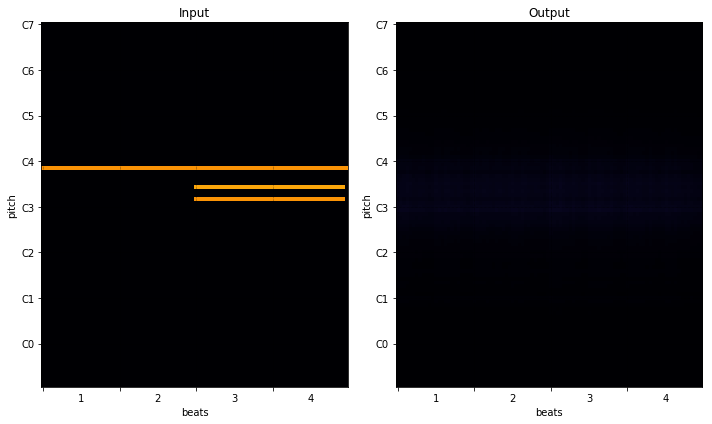

In [67]:
# Inspect a random input sample
sample_index = np.random.randint(len(input_test))
sample_input = input_test[sample_index].squeeze()
# Run test input through the autoencoder
sample_output = autoencoder.predict(sample_input[np.newaxis, ..., np.newaxis]).squeeze()
# sample_output = pianoroll_utils.pianoroll_preprocess(sample_output, MIN_PITCH, MAX_PITCH)

print(sample_input.shape)
print(sample_output.shape)
print(pianoroll_utils.get_active_pitch_classes(sample_input, MIN_PITCH, MAX_PITCH))
print(pianoroll_utils.get_active_pitch_classes(sample_output, MIN_PITCH, MAX_PITCH))
print(pianoroll_utils.pitch_intersection_over_union(sample_input, sample_output, MIN_PITCH, MAX_PITCH))
print(K.eval(custom_loss.get_active_pitch_classes_keras(sample_output[np.newaxis,...,np.newaxis])))
print(K.eval(custom_loss.pitch_loss(sample_input[np.newaxis,...,np.newaxis], sample_output[np.newaxis,...,np.newaxis])))

# Plot comparison
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 6, forward=True)
ax[0].set_title('Input')
ax[1].set_title('Output')
pianoroll_utils.plot_pianoroll(ax[0], sample_input, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
pianoroll_utils.plot_pianoroll(ax[1], sample_output, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# Play comparison
pianoroll_utils.play_pianoroll(sample_input, MIN_PITCH, MAX_PITCH, '0')
pianoroll_utils.play_pianoroll(sample_output, MIN_PITCH, MAX_PITCH, '1')

# 2. Latent spaces

A pretty big motivation behind this whole approach of learning intermediate embeddings, is the idea that we can learn a latent space which has some desirable properties including _smoothness_ and _realism_. With these properties, there are some important things we can do:

- Random sampling
- Latent arithmetic
- Latent interpolation

Each covered in its own subsection.

More information about VAEs and latent spaces in [this blogpost](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf).

In [ ]:
latent_dim = 500
epsilon_std = 1.0

MODEL_FILE = './models/vae_v7_encoder.h5'
encoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})
MODEL_FILE = './models/vae_v7_decoder.h5'
decoder = load_model(MODEL_FILE, 
                         custom_objects={'latent_dim': latent_dim, 'epsilon_std': epsilon_std})

### 2.1 Random sampling

Assuming our model managed to learn the latent space properly, we should be able to generate random samples from a normal distribution, and decode these random samples to generate realistic units.

In [ ]:
NUM_SAMPLES = 3 # Number of random units to generate

# Generate random vector
random_embed = np.random.normal(loc=0, scale=epsilon_std, size=(NUM_SAMPLES, latent_dim))

# Decode
random_units = decoder.predict(random_embed)

fig, ax = plt.subplots(NUM_SAMPLES, 1)
fig.set_size_inches(10, NUM_SAMPLES * 3, forward=True)
for i in range(NUM_SAMPLES):
    current_unit = random_units[i].squeeze()
    
    # Plot comparison
    ax[i].set_title('Random sample ' + str(i))
    pianoroll_utils.plot_pianoroll(ax[i], current_unit, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')

    # # Play comparison
    pianoroll_utils.play_pianoroll(current_unit, MIN_PITCH, MAX_PITCH, str(i))

### 2.2 Latent arithmetic

Basically, the idea behind latent arithmetic is that the latent variables capture meaningful features in their encoding, such that we can add and subtract latent variables, and get a latent result which can be reconstructed into something meaningful.

For example, some useful musical properties we could try to manipulate using latent arithmetic include:
1. Note velocity
2. Chord density
3. Note density
4. Pitch position (higher or lower octaves)
5. Musical forwardness (melody/background)

and possibly more.

In this section, we will try to construct latent vectors which capture the essence of these properties, and see if we can transform an input unit into a new unit with the desired properties.

#### Note velocity

In [ ]:
# Construct two units, one of high velocity and one of low velocity
c_major = [60, 64, 67, 72]
high_velocity_unit = np.zeros((NUM_PITCHES, NUM_TICKS))
high_velocity_unit[c_major, :] = 127
low_velocity_unit = np.zeros((NUM_PITCHES, NUM_TICKS))
low_velocity_unit[c_major, :] = 40

# Encode
high_velocity_unit_embed = encoder.predict(high_velocity_unit.reshape(1, NUM_PITCHES, NUM_TICKS, 1) / 127.)
low_velocity_unit_embed = encoder.predict(low_velocity_unit.reshape(1, NUM_PITCHES, NUM_TICKS, 1) / 127.)

# Calculate the latent vector for note velocity
positive_velocity_vector = high_velocity_unit_embed - low_velocity_unit_embed

#### Chord density

In [ ]:
# Construct two units, one of high velocity and one of low velocity
c_major = [60, 84]
c_major_dense = [60, 64, 67, 72, 76, 79, 84]
low_density_unit = np.zeros((NUM_PITCHES, NUM_TICKS))
low_density_unit[c_major, :] = 1
high_density_unit = np.zeros((NUM_PITCHES, NUM_TICKS))
high_density_unit[c_major_dense, :] = 1

# Encode
low_density_unit_embed = encoder.predict(low_density_unit.reshape(1, NUM_PITCHES, NUM_TICKS, 1))
high_density_unit_embed = encoder.predict(high_density_unit.reshape(1, NUM_PITCHES, NUM_TICKS, 1))

# Calculate the latent vector for chord density
positive_density_vector = high_density_unit_embed - low_density_unit_embed

#### Transposition

In [ ]:
# Construct two units, one of high velocity and one of low velocity
c_major = np.array([48, 52, 55, 60, 64, 67, 72])
d_major = c_major + 2
unit_1 = np.zeros((NUM_PITCHES, NUM_TICKS))
unit_1[c_major, :] = 0.5
unit_2 = np.zeros((NUM_PITCHES, NUM_TICKS))
unit_2[d_major, :] = 0.5

# Encode
unit_1_embed = encoder.predict(unit_1.reshape(1, NUM_PITCHES, NUM_TICKS, 1))
unit_2_embed = encoder.predict(unit_2.reshape(1, NUM_PITCHES, NUM_TICKS, 1))

# Calculate the latent vector for chord density
positive_transposition_vector = unit_2_embed - unit_1_embed

#### Visualization

In [ ]:
latent_operator = positive_transposition_vector

# Inspect a random input-output sample
sample_index = np.random.randint(len(input_test))
sample = input_test[sample_index].squeeze()

# Encode and apply latent vector
sample_embed = encoder.predict(sample.reshape(1, NUM_PITCHES, NUM_TICKS, 1))
sample_embed_transformed = sample_embed + latent_operator

# Decode
sample_decoded = decoder.predict(sample_embed)[0].squeeze()
sample_transformed_decoded = decoder.predict(sample_embed_transformed)[0].squeeze()

# Plot comparison
fig, ax = plt.subplots(3,1)
fig.set_size_inches(16, 10, forward=True)
ax[0].set_title('Original')
ax[1].set_title('Decoded')
ax[2].set_title('Transformed')
pianoroll_utils.plot_pianoroll(ax[0], sample, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
pianoroll_utils.plot_pianoroll(ax[1], sample_decoded, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
pianoroll_utils.plot_pianoroll(ax[2], sample_transformed_decoded, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')
fig.tight_layout()

# # Play comparison
pianoroll_utils.play_pianoroll(sample, MIN_PITCH, MAX_PITCH, '0')
pianoroll_utils.play_pianoroll(sample_decoded, MIN_PITCH, MAX_PITCH, '1')
pianoroll_utils.play_pianoroll(sample_transformed_decoded, MIN_PITCH, MAX_PITCH, '2')

### 2.3 Latent space interpolation

In [ ]:
# Grab two random samples
sample_index_1 = np.random.randint(len(input_test))
sample_1 = input_test[sample_index_1].squeeze()
sample_index_2 = np.random.randint(len(input_test))
sample_2 = input_test[sample_index_2].squeeze()

# Encode and apply latent vector
sample_embed_1 = encoder.predict(sample_1.reshape(1, NUM_PITCHES, NUM_TICKS, 1))
sample_embed_2 = encoder.predict(sample_2.reshape(1, NUM_PITCHES, NUM_TICKS, 1))

NUM_INTERPOLATIONS = 4
NUM_OUTPUTS = NUM_INTERPOLATIONS + 2 # One on each end of the interpolated values
NUM_PLOT_ROWS = int(np.ceil(NUM_OUTPUTS/2.)) # Two per row, round up if odd number

fig, ax = plt.subplots(NUM_PLOT_ROWS, 2)
fig.set_size_inches(10, NUM_PLOT_ROWS * 3, forward=True)
for i in range(NUM_OUTPUTS):
    alpha = float(i) / (NUM_INTERPOLATIONS + 1)
    sample_embed_interp = sample_embed_1 * (1 - alpha) + sample_embed_2 * alpha

    # Decode
    sample_decoded_interp = decoder.predict(sample_embed_interp)[0].squeeze()

    # Plot comparison
    ax[i/2, i%2].set_title('Interpolation, alpha = ' + ('%.2f' % alpha))
    pianoroll_utils.plot_pianoroll(ax[i/2, i%2], sample_decoded_interp, MIN_PITCH, MAX_PITCH, beat_resolution=24, cmap='inferno')

    # # Play comparison
    pianoroll_utils.play_pianoroll(sample_decoded_interp, MIN_PITCH, MAX_PITCH, str(i))

fig.tight_layout()
